## I want to know if ISMs with or without corresponding detected FSMs have a longer assc. GENCODE transcript length

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [10]:
# master table, no filtering (except gc biotype?)
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df.associated_gene_biotype.isin(['lncRNA', 'protein_coding'])]
# mt_df = mt_df.loc[mt_df['filter']=='pass']
# mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
#                       (mt_df.sample_sharing>1)

In [11]:
# get GENCODE IDs of all detected FSMs
fsm_gc_ids = mt_df.loc[mt_df.structural_category=='FSM', 'associated_transcriptid.v'].unique().tolist()
print(len(fsm_gc_ids))

104323


In [12]:
# get ISM-GENCODE pairs w/ unique GENCODE transcripts
ism_df = mt_df.loc[mt_df.structural_category=='ISM', ['structural_category', 'isoform', 'associated_transcriptid.v']].copy(deep=True)
ism_df['fsm_detected'] = ism_df['associated_transcriptid.v'].isin(fsm_gc_ids)

In [13]:
# how many isms do we have the fsm detected vs. not detected?
ism_df[['fsm_detected', 'isoform']].groupby('fsm_detected').nunique()

,isoform
fsm_detected,
False,17196
True,39809


In [14]:
# how many isms w/ uniq assc. tid do we have the fsm detected vs. not detected?
ism_df[['fsm_detected', 'associated_transcriptid.v']].groupby('fsm_detected').nunique()

,associated_transcriptid.v
fsm_detected,
False,10255
True,21838


In [ ]:
# get length of gencode transcripts 
ref_gtf_file = proc_cfg(config['ref']['gtf'], od)
gc_t_df = get_transcript_info(ref_gtf_file)

In [15]:
# merge in the lengths of transcripts w/ the ISMs
ism_df = ism_df.merge(gc_t_df[['tid', 't_len']], 
                      how='left', 
                      left_on='associated_transcriptid.v',
                      right_on='tid')

In [17]:
# get only unique fsm det assc. tid pairs
print(len(ism_df.index))
ism_df = ism_df[['associated_transcriptid.v', 'fsm_detected', 't_len']].drop_duplicates()
print(len(ism_df.index))

57005
32093


In [22]:
init_plot_settings(aspect='square')
c_dict, order = get_novelty_colors(['ISM'])
c = c_dict['ISM']
print(c)
c_dict, order = get_shade_colors(c, [True, False])

#8EDE95


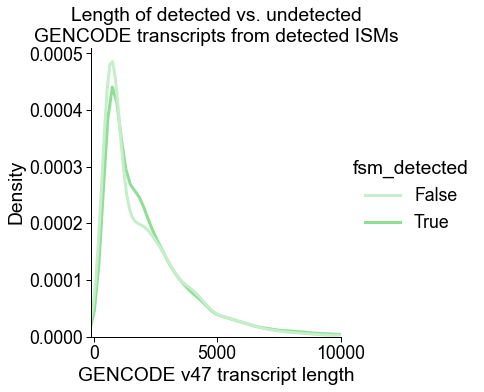

In [31]:
ax = sns.displot(ism_df, x='t_len',
                 hue='fsm_detected',
                 kind='kde',
                 linewidth=3,
                 palette=c_dict, 
                 common_norm=False)
xlabel = 'GENCODE v47 transcript length'
title = 'Length of detected vs. undetected\n'+\
         'GENCODE transcripts from detected ISMs'
ax.set(xlabel=xlabel, title=title, xlim=(-100,10000))

In [38]:
# test whether ISMs w/ detected FSMs have shorter associated transcripts
# this means null hypothesis is that detected FSM transcripts are longer 

fsm_det = x = ism_df.loc[ism_df.fsm_detected==True, 't_len'].tolist() # should be shorter # null = longer
fsm_undet = y = ism_df.loc[ism_df.fsm_detected==False, 't_len'].tolist() # should be longer

st.mannwhitneyu(fsm_det, fsm_undet,
                      alternative='less')

# not significant

MannwhitneyuResult(statistic=118329565.0, pvalue=0.9999999999999999)